/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

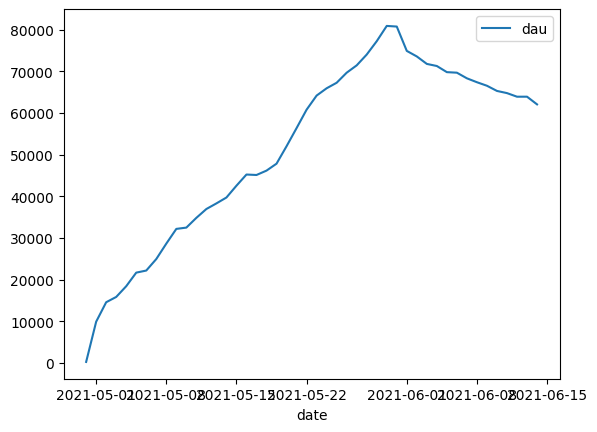

In [ ]:

from DreamGamesAnalytics import DreamGamesAnalytics
service_account_path = '/home/yusuf/DataScience/dream_games/ybektas20.json'
analytics = DreamGamesAnalytics(service_account_path)
# ARPDAU grouped by date/platform/network/country
dau_trend = analytics.get_dau_trend().set_index('date')
dau_trend.plot()


### USER ENGAGEMENT

In [2]:
dau_by_country = analytics.get_dau_by_country()
dau_by_country

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,country,dau
0,2021-04-30,Mercury,80
1,2021-04-30,Pluton,41
2,2021-04-30,Uranus,2
3,2021-04-30,Venus,94
4,2021-05-01,Mercury,4659
...,...,...,...
224,2021-06-14,Mercury,25588
225,2021-06-14,Pluton,19090
226,2021-06-14,Saturn,2121
227,2021-06-14,Uranus,1252


<Axes: xlabel='date'>

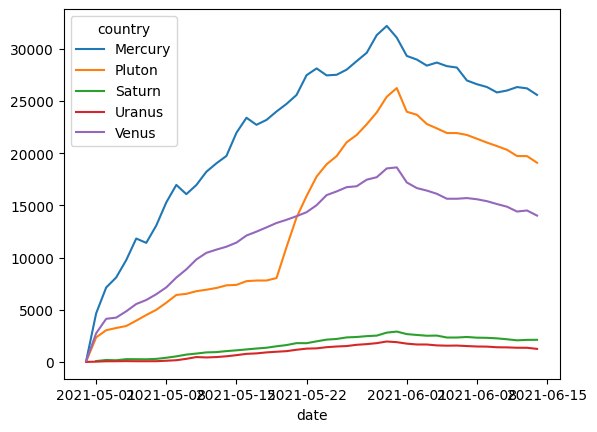

In [3]:
dau_by_country.pivot(index='date', columns='country', values='dau').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

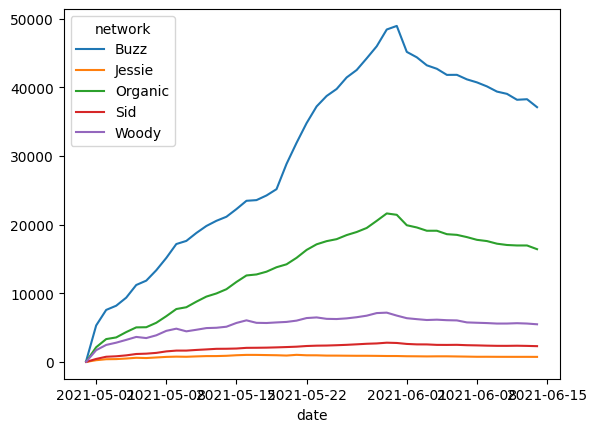

In [4]:
dau_by_network = analytics.get_dau_by_network()
dau_by_network.pivot(index='date', columns='network', values='dau').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

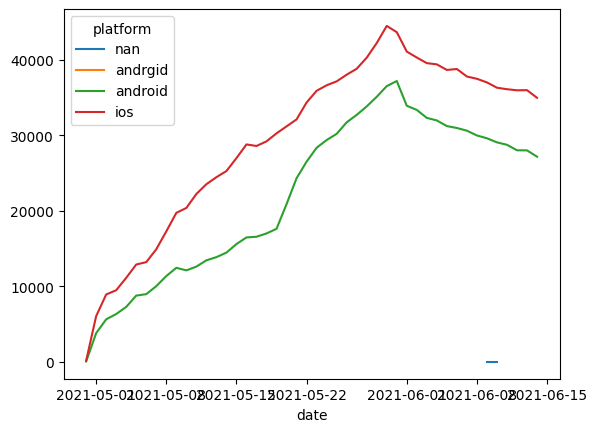

In [5]:
dau_by_platform = analytics.get_dau_by_platform()
dau_by_platform.pivot(index='date', columns='platform', values='dau').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'Installs'}, xlabel='install_date'>

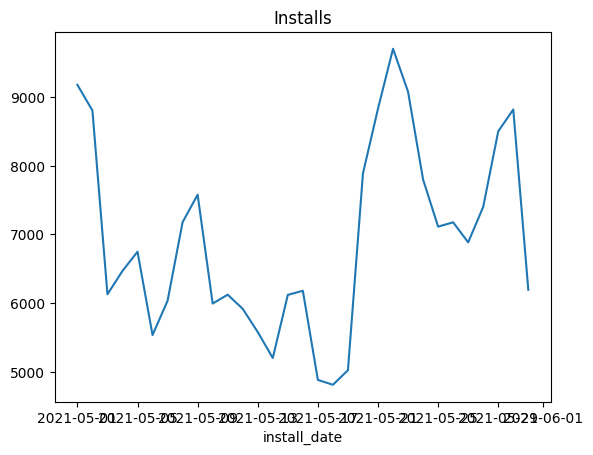

In [6]:
retention_trend = analytics.get_retention_trend().set_index('install_date')
retention_trend.installs.iloc[1:-1].plot(title='Installs')


<Axes: title={'center': 'Day 1 Retention'}, xlabel='install_date'>

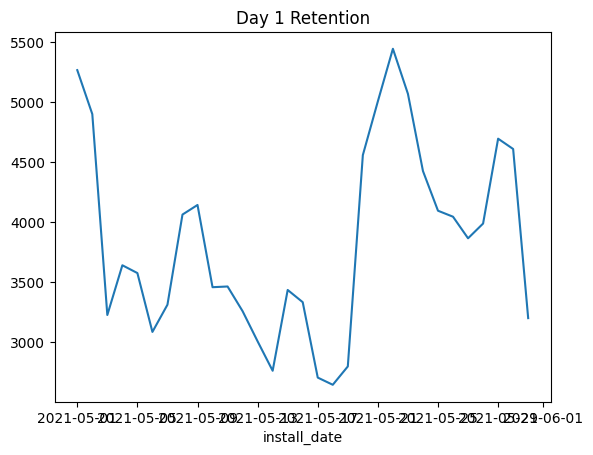

In [7]:
retention_trend.retained_day1.iloc[1:-1].plot(title='Day 1 Retention')

<Axes: title={'center': 'Day 1 Retention Rate'}, xlabel='install_date'>

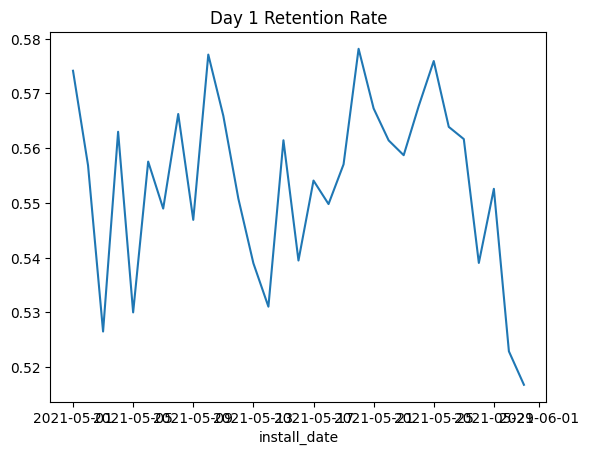

In [8]:
retention_trend.retention_day1.iloc[1:-1].plot(title='Day 1 Retention Rate')

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='install_date'>

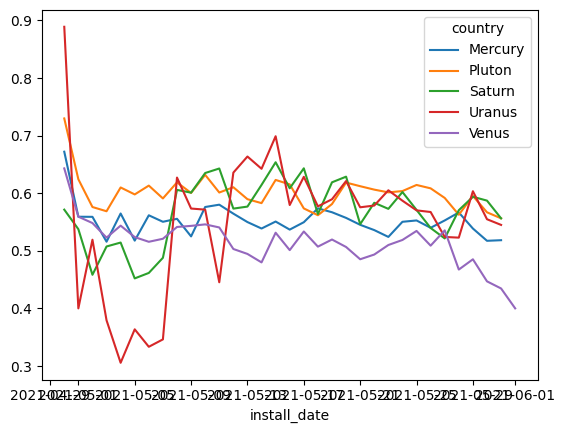

In [9]:
retention_by_country = analytics.get_retention_by_country()
retention_by_country.pivot(index='install_date', columns='country', values='retention_day1').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='install_date'>

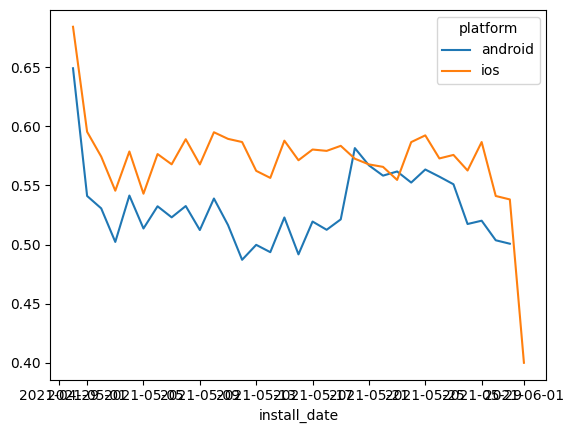

In [10]:
retention_by_platform = analytics.get_retention_by_platform()
retention_by_platform.pivot(index='install_date', columns='platform', values='retention_day1').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='install_date'>

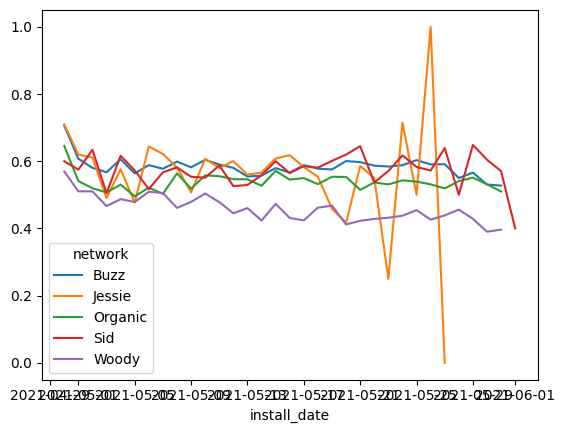

In [11]:
retention_by_network = analytics.get_retention_by_network()
retention_by_network.pivot(index='install_date', columns='network', values='retention_day1').plot()

In [12]:
avg_time_spent = analytics.get_avg_time_spent()
avg_time_spent.describe()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,day_of_week,hour_of_day,avg_time_spent
count,840.0,840.0,840.000000
mean,4.0,11.5,1236.893407
std,2.001192,6.926311,201.729195
min,1.0,0.0,857.298387
25%,2.0,5.75,1100.709666
50%,4.0,11.5,1196.709875
75%,6.0,17.25,1338.331681
max,7.0,23.0,2400.860900


<Axes: title={'center': 'Time Spent by Hour of Day'}, xlabel='hour_of_day'>

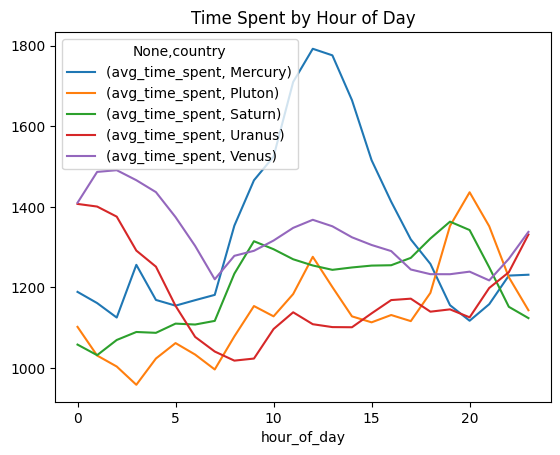

In [13]:
avg_time_spent.groupby(['hour_of_day','country']).agg({'avg_time_spent': 'mean'}).unstack().plot(title='Time Spent by Hour of Day')


<Axes: title={'center': 'Time Spent by Day of Week'}, xlabel='day_of_week'>

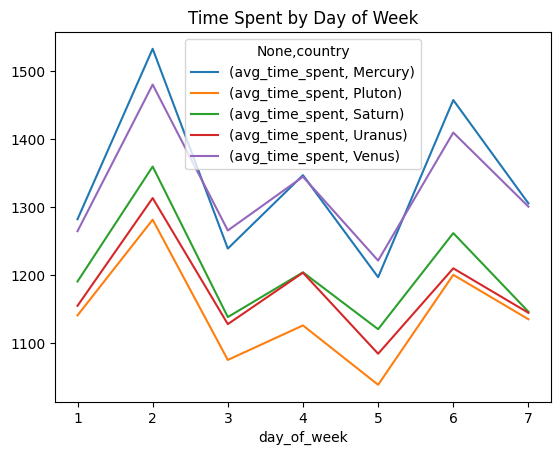

In [14]:
avg_time_spent.groupby(['day_of_week','country']).agg({'avg_time_spent': 'mean'}).unstack().plot(title='Time Spent by Day of Week')

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'Number of People Passing Each Level'}, xlabel='level'>

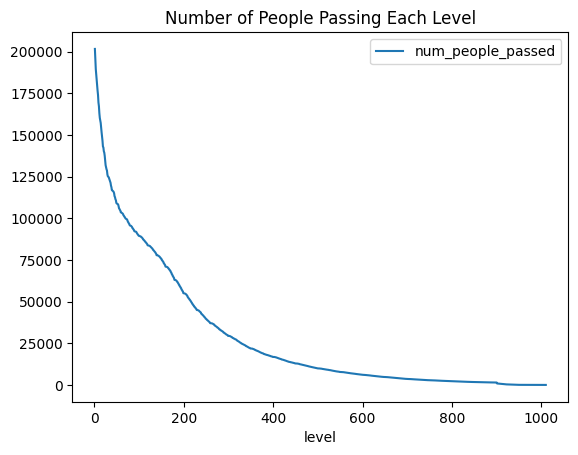

In [15]:

number_of_peoples_passing_level = analytics.get_number_of_people_passing_level()
number_of_peoples_passing_level = number_of_peoples_passing_level.set_index('level')
number_of_peoples_passing_level.plot(title='Number of People Passing Each Level')

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'Avg Time Spent per Level'}, xlabel='level'>

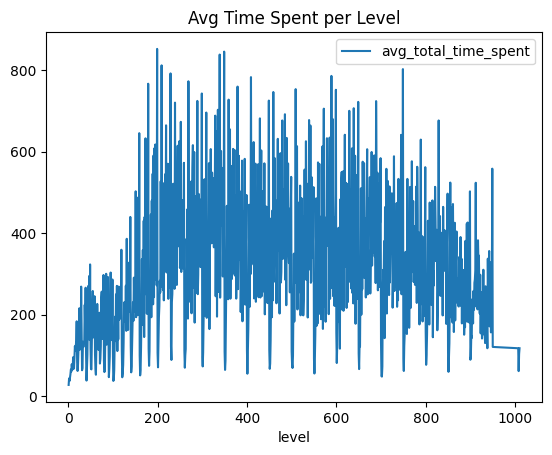

In [16]:
avg_time_per_level = analytics.get_avg_time_spent_per_level()
avg_time_per_level = avg_time_per_level.set_index('level')
avg_time_per_level.plot(title='Avg Time Spent per Level')


In [17]:
query = """
SELECT
  level,
  COUNT(*) AS num_attempts,
  COUNT(DISTINCT (moves_made + moves_left)) AS distinct_total_moves,
  MIN(moves_made + moves_left) AS common_total_moves_min,
  MAX(moves_made + moves_left) AS common_total_moves_max
FROM `casedreamgames.case_db.q1_table_level_end`
GROUP BY level
ORDER BY level;

"""
moves = analytics._run_query(query)
moves

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,level,num_attempts,distinct_total_moves,common_total_moves_min,common_total_moves_max
0,1,205194,1,25,25
1,2,195403,2,30,35
2,3,189887,2,25,30
3,4,186603,2,30,35
4,5,182545,2,30,35
...,...,...,...,...,...
949,950,48,1,25,25
950,1007,1,1,40,40
951,1008,1,1,26,26
952,1009,1,1,32,32


<Axes: title={'center': 'Range of Total Moves'}>

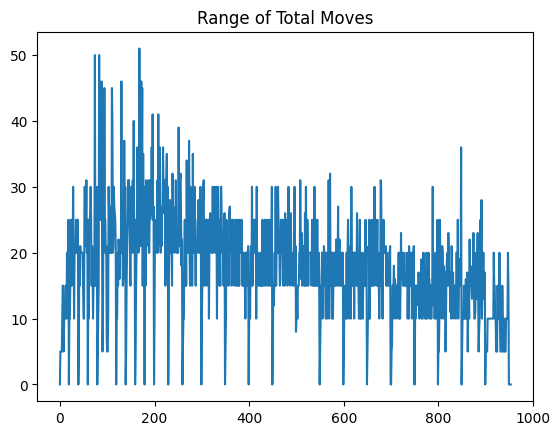

In [18]:
(moves.common_total_moves_max-moves.common_total_moves_min).plot(title='Range of Total Moves')


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'Average Moves Ratio per Level'}, xlabel='level'>

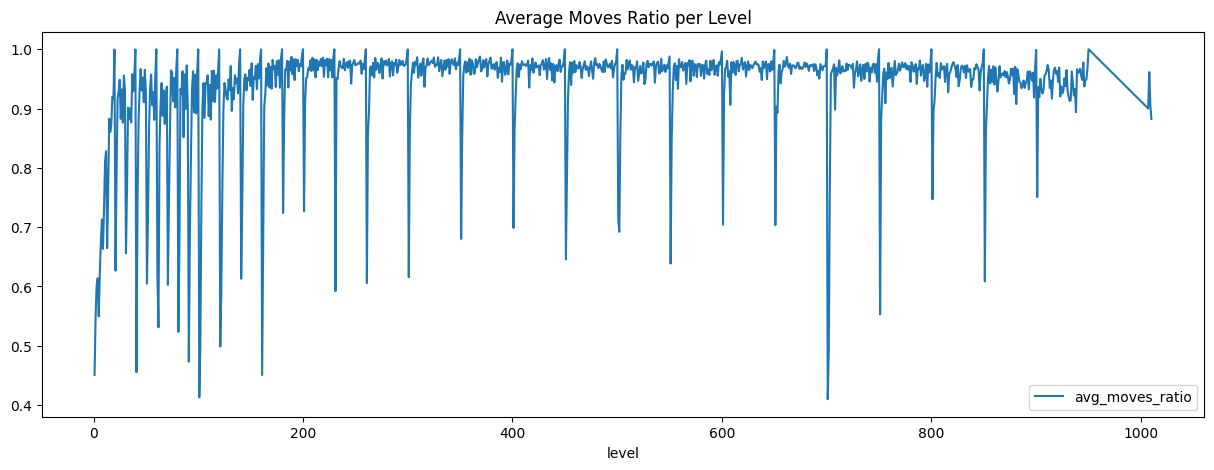

In [19]:
query = """
SELECT
  level,
  AVG(SAFE_DIVIDE(moves_made, moves_made + moves_left)) AS avg_moves_ratio
FROM `casedreamgames.case_db.q1_table_level_end`
GROUP BY level
ORDER BY level;

"""
moves_ratio_by_level = analytics._run_query(query)
moves_ratio_by_level = moves_ratio_by_level.set_index('level')
moves_ratio_by_level.plot(title='Average Moves Ratio per Level', figsize=(15,5))

<Axes: title={'center': 'Average Moves Ratio per Level'}, xlabel='level'>

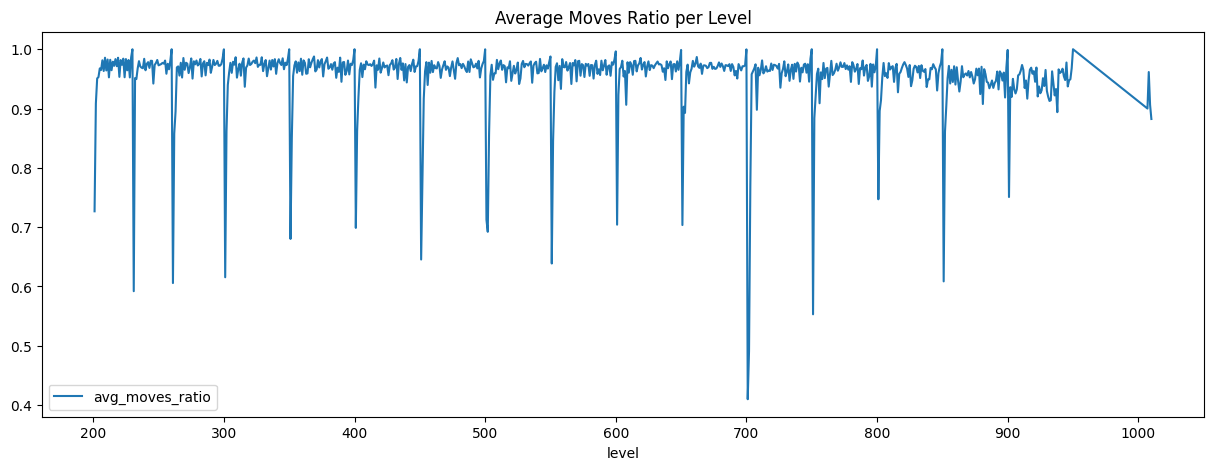

In [20]:
moves_ratio_by_level.iloc[200:].plot(title='Average Moves Ratio per Level', figsize=(15,5))


In [29]:
moves_ratio_by_level[moves_ratio_by_level.avg_moves_ratio < moves_ratio_by_level.quantile(0.05).values[0]]


,avg_moves_ratio
level,
1,0.450792
2,0.549208
3,0.602438
4,0.613794
5,0.549526
6,0.621796
7,0.673226
8,0.712845
9,0.663322


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'Avg Total Time Spent per Level (Only Wins)'}, xlabel='level'>

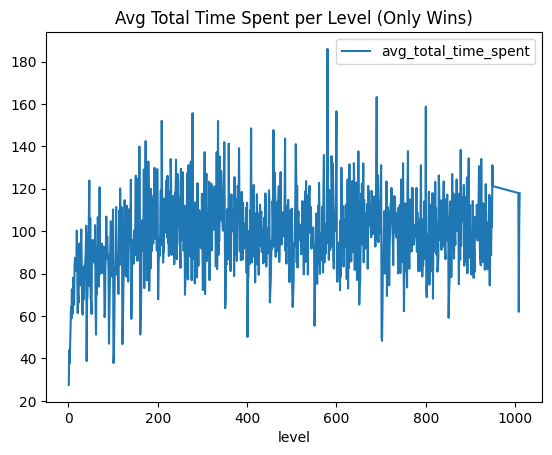

In [30]:
query = """
WITH user_level_time AS (
    SELECT
    level,
    user_id,
    SUM(time_spent) AS total_time_spent
    FROM `casedreamgames.case_db.q1_table_level_end`
    WHERE status = 'win'
    GROUP BY 1, 2
)
SELECT
    level,
    AVG(total_time_spent) AS avg_total_time_spent
FROM user_level_time
GROUP BY level
ORDER BY level;
"""
avg_total_time_spent_per_level_passed = analytics._run_query(query)
avg_total_time_spent_per_level_passed = avg_total_time_spent_per_level_passed.set_index('level')
avg_total_time_spent_per_level_passed.plot(title='Avg Total Time Spent per Level (Only Wins)')


<Axes: title={'center': 'ratio of avg time spent to until win avg total time spent when won per level'}, xlabel='level'>

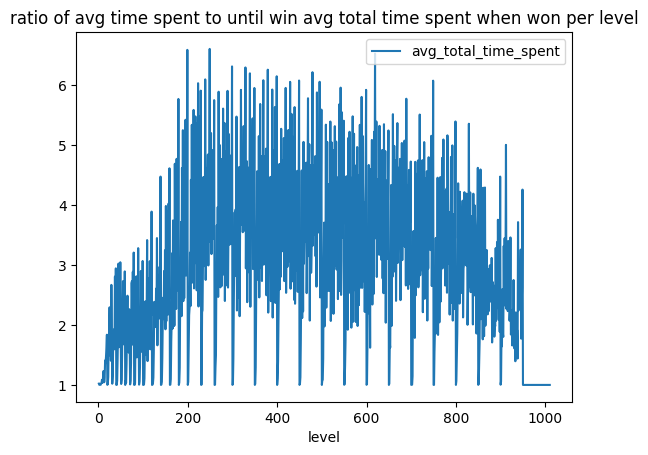

In [31]:
(avg_time_per_level/avg_total_time_spent_per_level_passed).plot(title='ratio of avg time spent to until win avg total time spent when won per level')

<Axes: title={'center': 'Log Difference of Median Time Spent per Level'}, xlabel='level'>

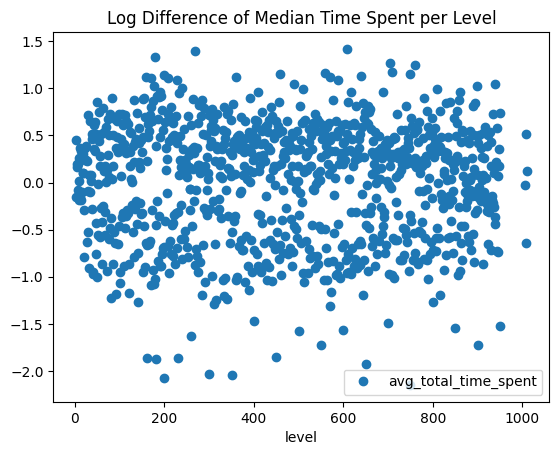

In [32]:
import numpy as np
avg_time_by_level_diff=np.log(avg_time_per_level).diff().iloc[1:]
avg_time_by_level_diff.plot(style='o', title='Log Difference of Median Time Spent per Level')

In [33]:
avg_time_spent_on_last_failed_level = analytics.get_avg_time_spent_on_last_failed_level()
avg_time_spent_on_last_failed_level = avg_time_spent_on_last_failed_level.set_index('level')
avg_time_spent_on_last_failed_level

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,num_users,avg_time_spent_on_last_failed_level
level,,
3,8,103.750000
4,10,130.300000
5,26,110.384615
6,161,153.422360
7,202,108.301980
...,...,...
945,7,112.285714
946,3,87.000000
947,2,128.000000


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


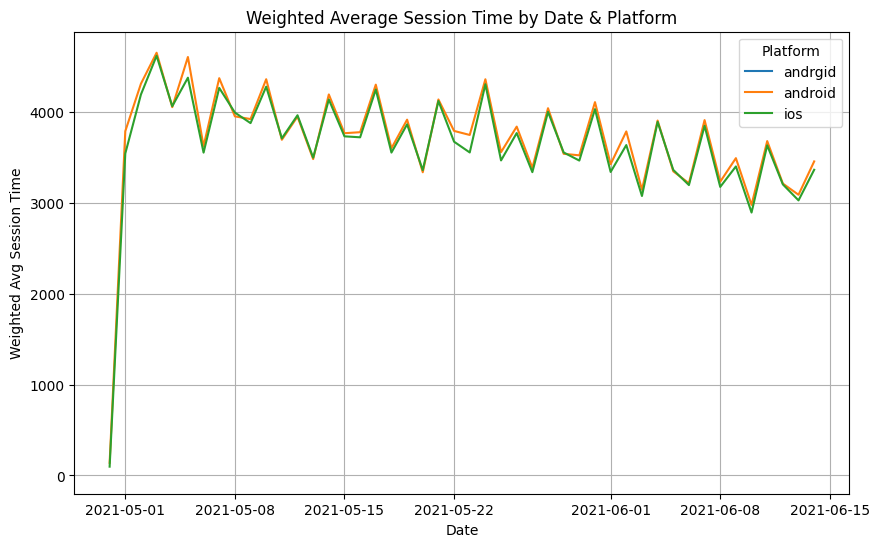

In [34]:
import pandas as pd

def weighted_avg_pivot(
    df: pd.DataFrame,
    index_cols: str | list[str],
    pivot_cols: str | list[str],
    value_col: str = 'avg_session_time_per_user',
    weight_col: str = 'user_count',
    fill_value: float = 0
) -> pd.DataFrame:

    df = df.copy()

    df['weighted_value'] = df[value_col] * df[weight_col]

    pivot_sums = pd.pivot_table(
        data=df,
        index=index_cols,
        columns=pivot_cols,
        values=['weighted_value', weight_col],
        aggfunc='sum',
        fill_value=fill_value
    )

    sum_weighted = pivot_sums['weighted_value']
    sum_weights = pivot_sums[weight_col]

    weighted_avg_df = sum_weighted / sum_weights

    # 5. Clean up the new pivot DataFrame
    weighted_avg_df.columns.name = None  # remove the top-level name
    weighted_avg_df.rename_axis(None, axis=1, inplace=True)

    return weighted_avg_df


avg_time_spent_by_groups = analytics.get_avg_time_spent_by_groups()

avg_time_spent_by_platform = weighted_avg_pivot(
    df=avg_time_spent_by_groups,
    index_cols='date',
    pivot_cols='platform'
)


import seaborn as sns
import matplotlib.pyplot as plt

avg_time_spent_by_platform.plot(figsize=(10,6))
plt.title('Weighted Average Session Time by Date & Platform')
plt.xlabel('Date')
plt.ylabel('Weighted Avg Session Time')
plt.legend(title='Platform')
plt.grid(True)
plt.show()



<Axes: xlabel='date'>

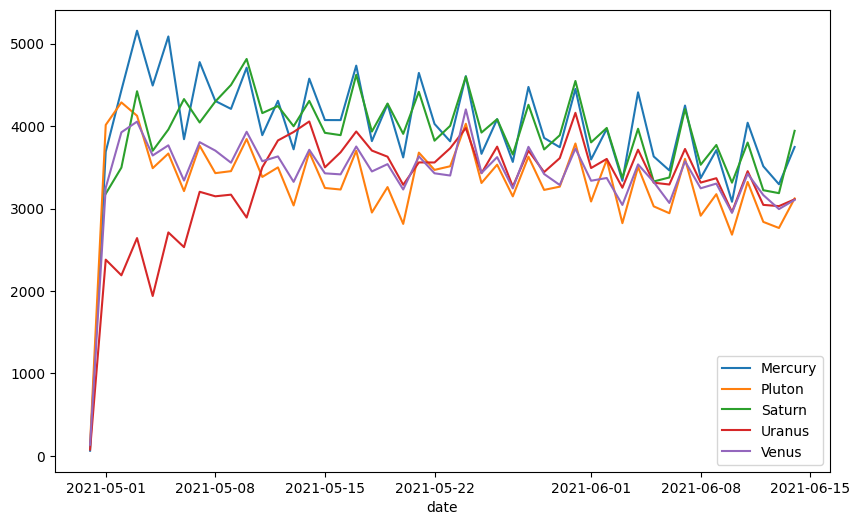

In [35]:
avg_time_spent_by_country = weighted_avg_pivot(
    df=avg_time_spent_by_groups,
    index_cols='date',
    pivot_cols='country'
)

avg_time_spent_by_country.plot(figsize=(10,6))

<Axes: xlabel='date'>

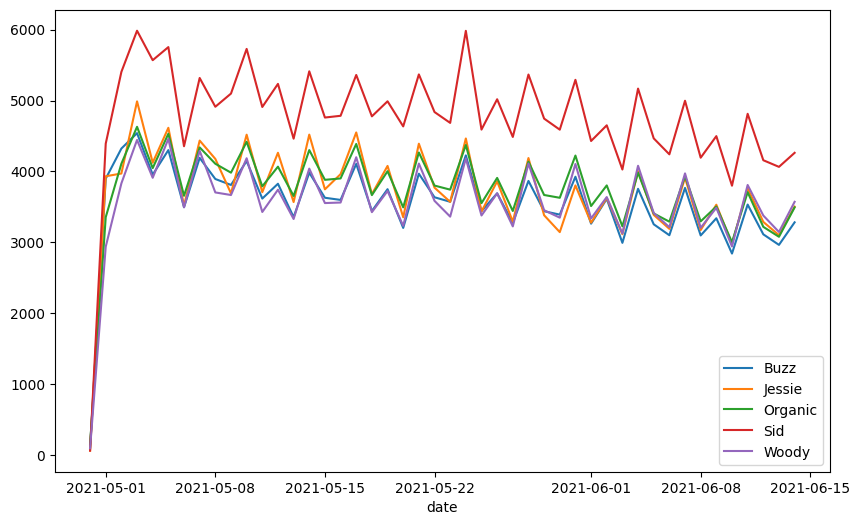

In [36]:
avg_time_spent_by_network = weighted_avg_pivot(
    df=avg_time_spent_by_groups,
    index_cols='date',
    pivot_cols='network'
)

avg_time_spent_by_network.plot(figsize=(10,6))

### Cost Analysis

In [37]:
cost = analytics.get_cost()
cost

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,network,country,platform,cost
0,2021-05-01,Buzz,Mercury,android,5271.0
1,2021-05-01,Buzz,Pluton,android,299.0
2,2021-05-01,Buzz,Saturn,android,3.0
3,2021-05-01,Buzz,Uranus,android,13.0
4,2021-05-01,Buzz,Venus,android,1095.0
...,...,...,...,...,...
1352,2021-05-31,Woody,Mercury,ios,1430.0
1353,2021-05-31,Woody,Pluton,ios,0.0
1354,2021-05-31,Woody,Saturn,ios,0.0
1355,2021-05-31,Woody,Uranus,ios,0.0


<Axes: title={'center': 'Cost by Network'}, xlabel='date'>

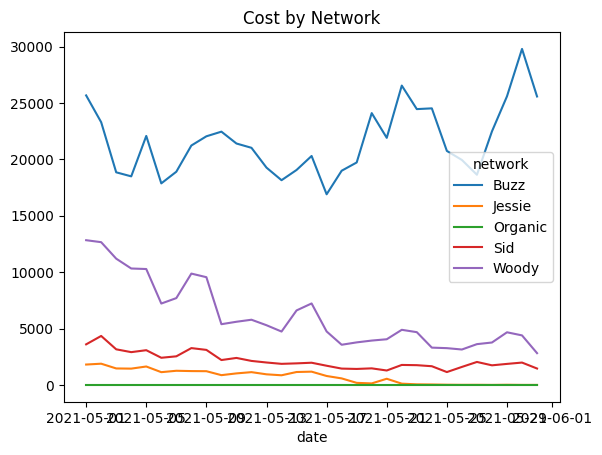

In [38]:
cost.groupby(['date', 'network']).cost.sum().unstack().plot(title='Cost by Network')

<Axes: title={'center': 'Cost by Platform'}, xlabel='date'>

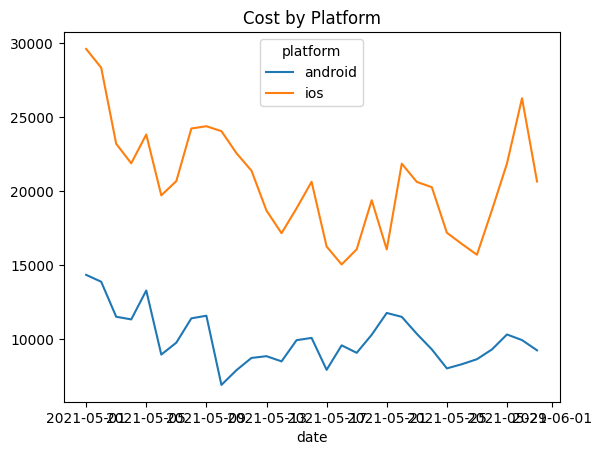

In [39]:
cost.groupby(['date', 'platform']).cost.sum().unstack().plot(title='Cost by Platform')

<Axes: title={'center': 'Cost by Country'}, xlabel='date'>

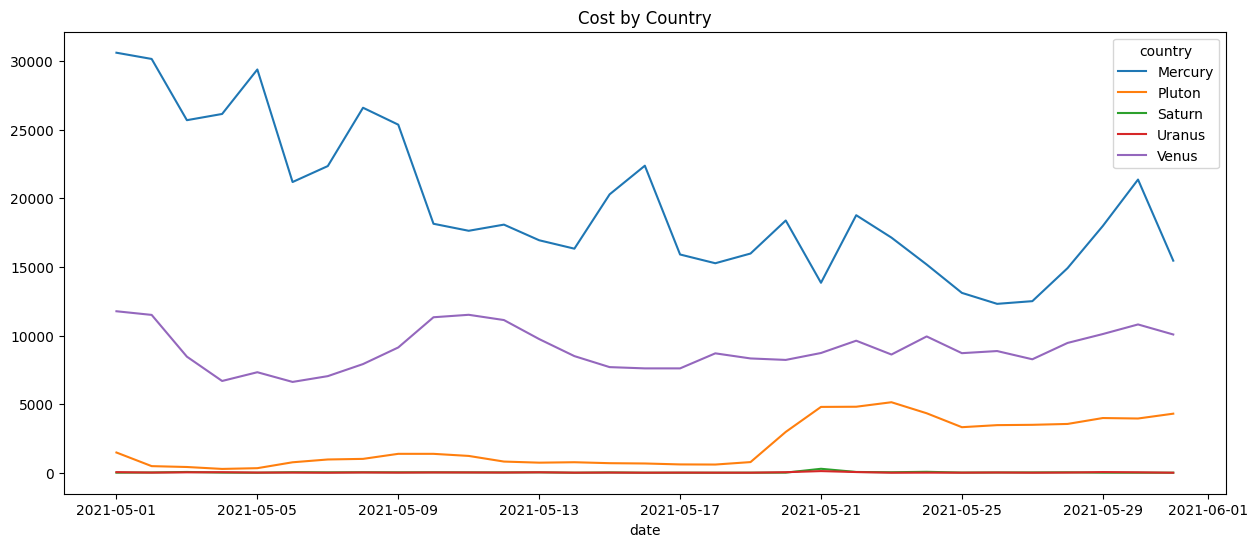

In [40]:
cost.groupby(['date', 'country']).cost.sum().unstack().plot(title='Cost by Country', figsize=(15,6))

In [41]:
cost_per_install = analytics.get_cost_per_install()
cost_per_install

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,date,country,platform,network,installs,total_cost
0,2021-04-30,Mercury,android,Buzz,85,0.0
1,2021-04-30,Mercury,android,Jessie,8,0.0
2,2021-04-30,Mercury,android,Organic,25,0.0
3,2021-04-30,Mercury,android,Sid,6,0.0
4,2021-04-30,Mercury,android,Woody,44,0.0
...,...,...,...,...,...,...
921,2021-05-31,Venus,ios,Buzz,510,4695.0
922,2021-05-31,Venus,ios,Organic,133,0.0
923,2021-05-31,Venus,ios,Sid,95,897.0
924,2021-05-31,Venus,ios,Woody,9,49.0


In [42]:
common_dates = set(cost.date).intersection(set(cost_per_install.date))
cost_per_install = cost_per_install[cost_per_install.date.isin(common_dates)]
cost = cost[cost.date.isin(common_dates)]


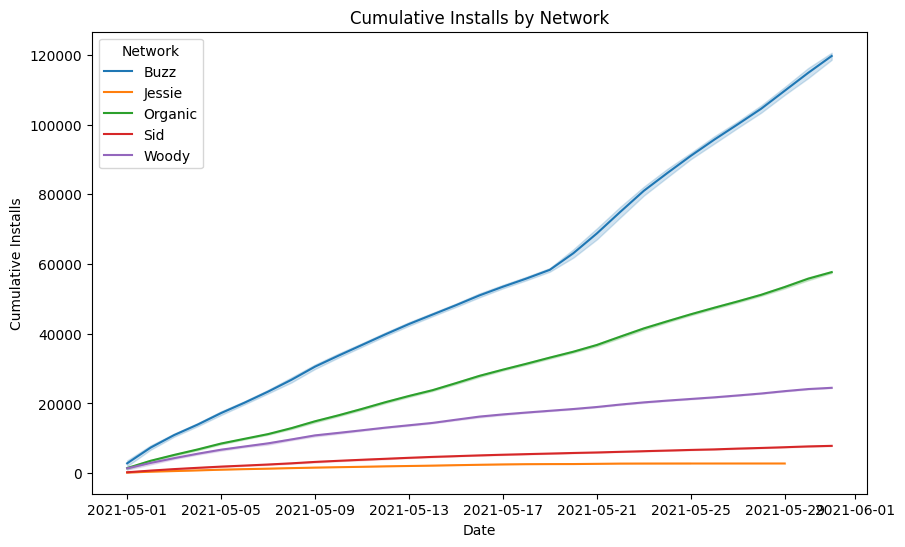

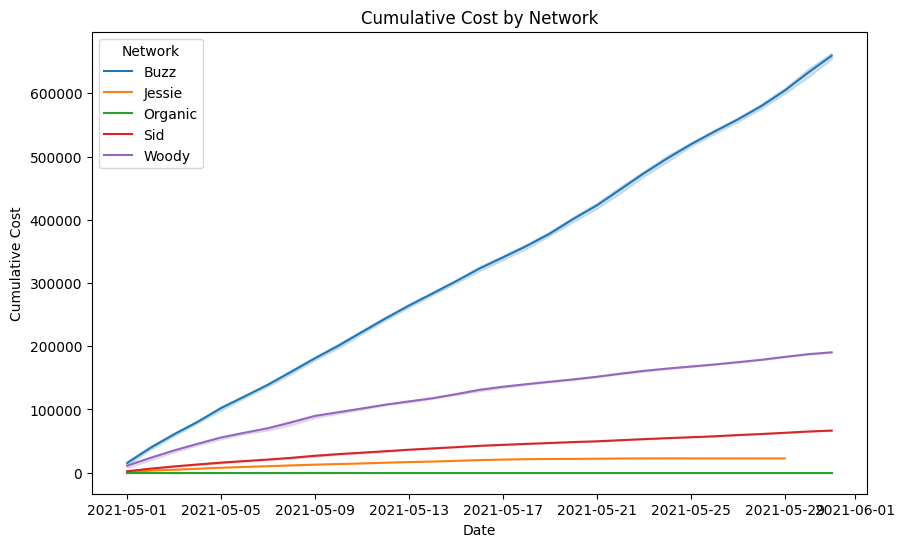

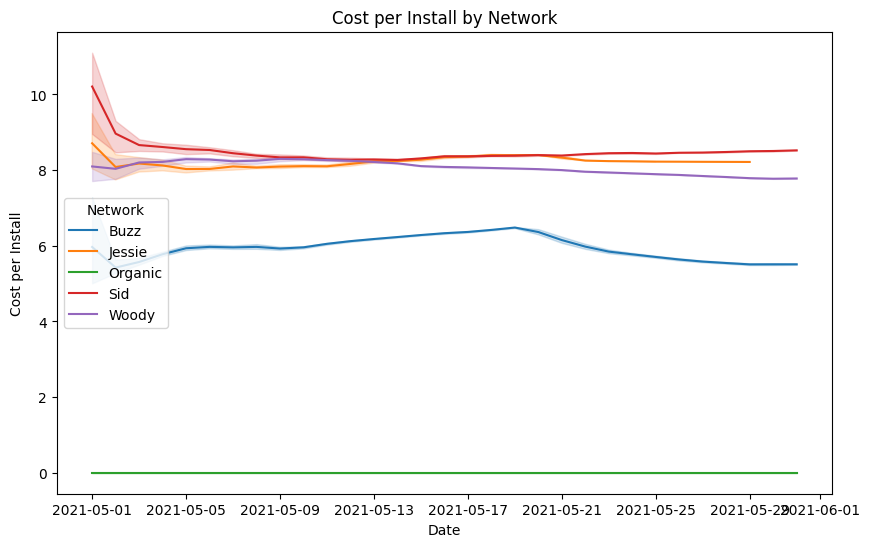

In [43]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = cost_per_install.copy()
# 1. Convert your 'date' column to datetime if needed
df['date'] = pd.to_datetime(df['date'])

# 2. Sort by network and then by date
df = df.sort_values(by=['network', 'date'])

# 3. Compute cumulative sums for each network
df['cumulative_installs'] = df.groupby('network')['installs'].cumsum()
df['cumulative_cost'] = df.groupby('network')['total_cost'].cumsum()
df['cost_per_install'] = df['cumulative_cost'] / df['cumulative_installs']



# 4A. Plot cumulative installs by network
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='cumulative_installs', hue='network')
plt.title('Cumulative Installs by Network')
plt.xlabel('Date')
plt.ylabel('Cumulative Installs')
plt.legend(title='Network')
plt.show()

# 4B. Plot cumulative cost by network
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='cumulative_cost', hue='network')
plt.title('Cumulative Cost by Network')
plt.xlabel('Date')
plt.ylabel('Cumulative Cost')
plt.legend(title='Network')
plt.show()

# 4C. Plot cost per install by network
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='cost_per_install', hue='network')
plt.title('Cost per Install by Network')
plt.xlabel('Date')
plt.ylabel('Cost per Install')
plt.legend(title='Network')
plt.show()


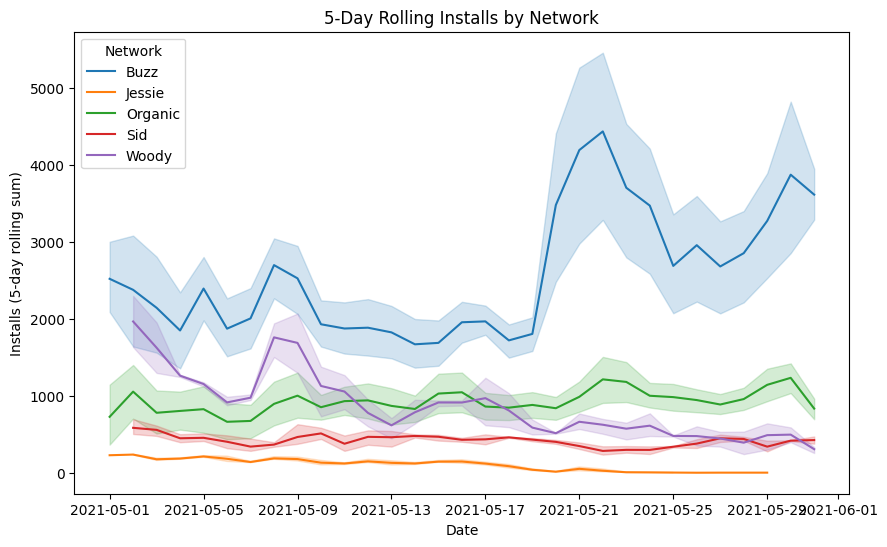

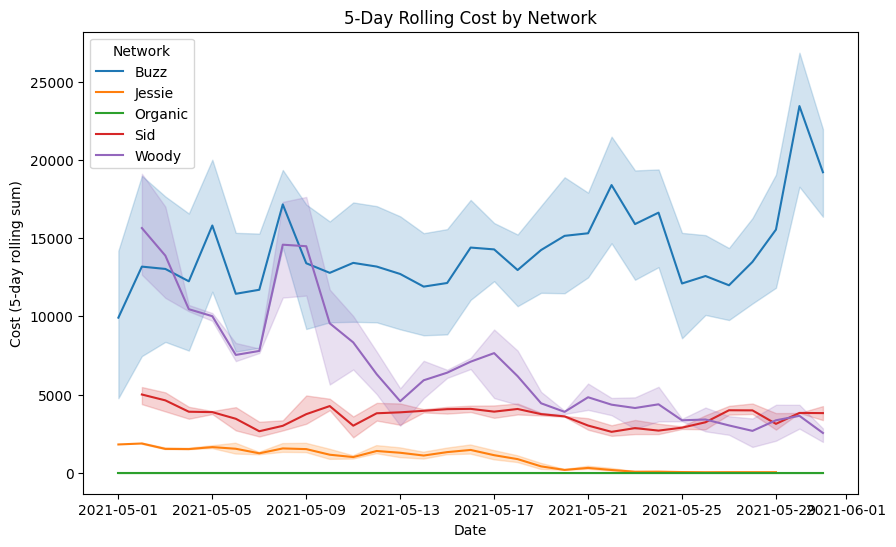

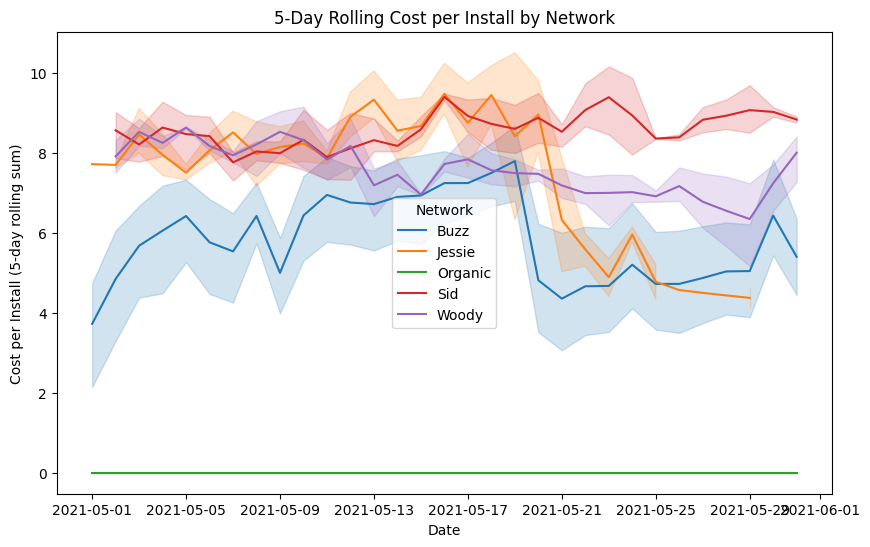

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assume your dataframe is df, with columns: date, country, platform, network, installs, total_cost

# 1. Ensure 'date' is a datetime
df['date'] = pd.to_datetime(df['date'])

# 2. Sort by network and date
df = df.sort_values(by=['network', 'date'])

# 3. Compute rolling 5-day sum for installs and cost, grouped by network
#    Here rolling(5) means a 5-row window. 
#    If your data is daily and has no missing dates, this typically covers 5 days. 
#    If you need a strict time-based window (e.g., 5 calendar days), see the note below.
df['rolling_5_installs'] = df.groupby('network')['installs'].transform(lambda x: x.rolling(5).sum())
df['rolling_5_cost'] = df.groupby('network')['total_cost'].transform(lambda x: x.rolling(5).sum())
df['rolling_5_cost_per_install'] = df['rolling_5_cost'] / df['rolling_5_installs']

# 4A. Plot 5-day rolling installs by network
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='rolling_5_installs', hue='network')
plt.title('5-Day Rolling Installs by Network')
plt.xlabel('Date')
plt.ylabel('Installs (5-day rolling sum)')
plt.legend(title='Network')
plt.show()

# 4B. Plot 5-day rolling cost by network
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='rolling_5_cost', hue='network')
plt.title('5-Day Rolling Cost by Network')
plt.xlabel('Date')
plt.ylabel('Cost (5-day rolling sum)')
plt.legend(title='Network')
plt.show()

# 4C. Plot 5-day rolling cost per install by network
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='date', y='rolling_5_cost_per_install', hue='network')
plt.title('5-Day Rolling Cost per Install by Network')
plt.xlabel('Date')
plt.ylabel('Cost per Install (5-day rolling sum)')
plt.legend(title='Network')
plt.show()



In [45]:
import pandas as pd

df_cp = cost_per_install.groupby(['date', 'country', 'platform'], as_index=False).agg({
    'installs': 'sum',
    'total_cost': 'sum'
})

# Convert date column to datetime and sort
df_cp['date'] = pd.to_datetime(df_cp['date'])
df_cp = df_cp.sort_values(by=['country', 'platform', 'date'])

df_cp.head()


,date,country,platform,installs,total_cost
0,2021-05-01,Mercury,android,1977,12814.0
10,2021-05-02,Mercury,android,1993,12369.0
20,2021-05-03,Mercury,android,1496,10158.0
30,2021-05-04,Mercury,android,1702,10231.0
40,2021-05-05,Mercury,android,1724,11365.0


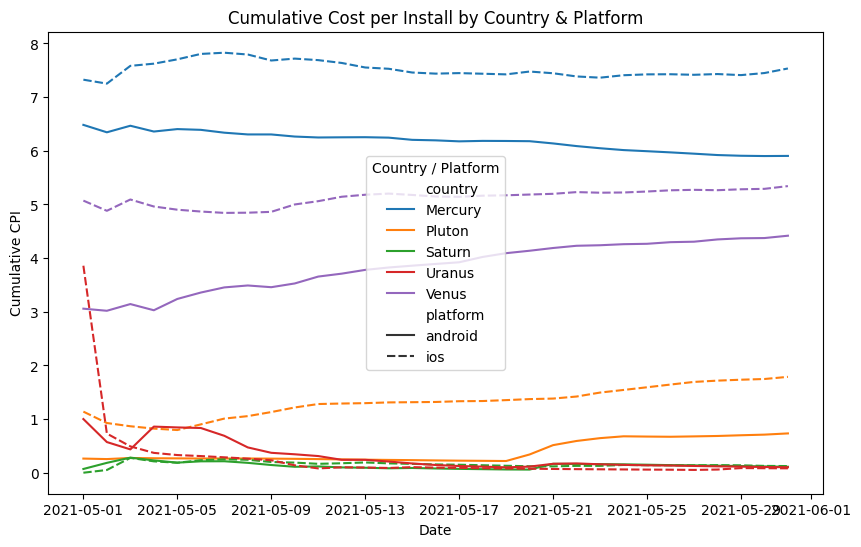

In [46]:
df_cp['cumulative_installs'] = df_cp.groupby(['country', 'platform'])['installs'].cumsum()
df_cp['cumulative_cost'] = df_cp.groupby(['country', 'platform'])['total_cost'].cumsum()

# If cumulative_installs is 0, cost_per_install might be undefined; handle with fill or mask
df_cp['cumulative_cpi'] = df_cp['cumulative_cost'] / df_cp['cumulative_installs']
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.lineplot(data=df_cp, x='date', y='cumulative_cpi', 
             hue='country', style='platform')
plt.title('Cumulative Cost per Install by Country & Platform')
plt.xlabel('Date')
plt.ylabel('Cumulative CPI')
plt.legend(title='Country / Platform')
plt.show()



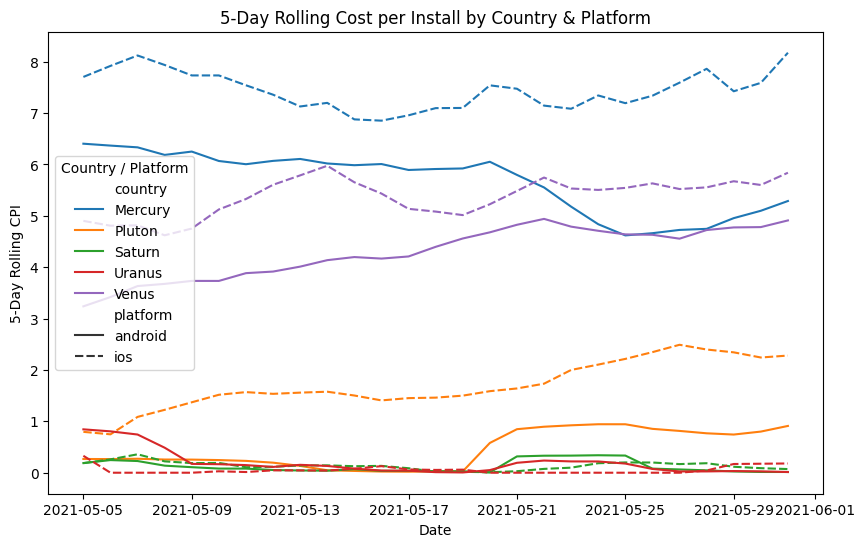

In [47]:
# Rolling 5-day sums of installs and cost
df_cp['rolling_5_installs'] = df_cp.groupby(['country','platform'])['installs'] \
                                   .transform(lambda x: x.rolling(5).sum())
df_cp['rolling_5_cost'] = df_cp.groupby(['country','platform'])['total_cost'] \
                                .transform(lambda x: x.rolling(5).sum())

# Rolling 5-day cost per install
df_cp['rolling_5_cpi'] = df_cp['rolling_5_cost'] / df_cp['rolling_5_installs']


plt.figure(figsize=(10,6))
sns.lineplot(data=df_cp, x='date', y='rolling_5_cpi', 
             hue='country', style='platform')
plt.title('5-Day Rolling Cost per Install by Country & Platform')
plt.xlabel('Date')
plt.ylabel('5-Day Rolling CPI')
plt.legend(title='Country / Platform')
plt.show()

In [48]:
cost_per_install =cost_per_install.set_index('date')
cost_per_install

,country,platform,network,installs,total_cost
date,,,,,
2021-05-01,Mercury,android,Buzz,689,5271.0
2021-05-01,Mercury,android,Jessie,75,590.0
2021-05-01,Mercury,android,Organic,346,0.0
2021-05-01,Mercury,android,Sid,95,1073.0
2021-05-01,Mercury,android,Woody,772,5880.0
...,...,...,...,...,...
2021-05-31,Venus,android,Woody,9,31.0
2021-05-31,Venus,ios,Buzz,510,4695.0
2021-05-31,Venus,ios,Organic,133,0.0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     13.14
Date:                Thu, 20 Feb 2025   Prob (F-statistic):            0.00110
Time:                        12:54:45   Log-Likelihood:                -262.07
No. Observations:                  31   AIC:                             528.1
Df Residuals:                      29   BIC:                             531.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2137.0158   1338.813      1.596      0.1

/tmp/ipykernel_4196/1190524342.py:11: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  df_total = df_total.groupby(df_total.index, as_index=False).agg({


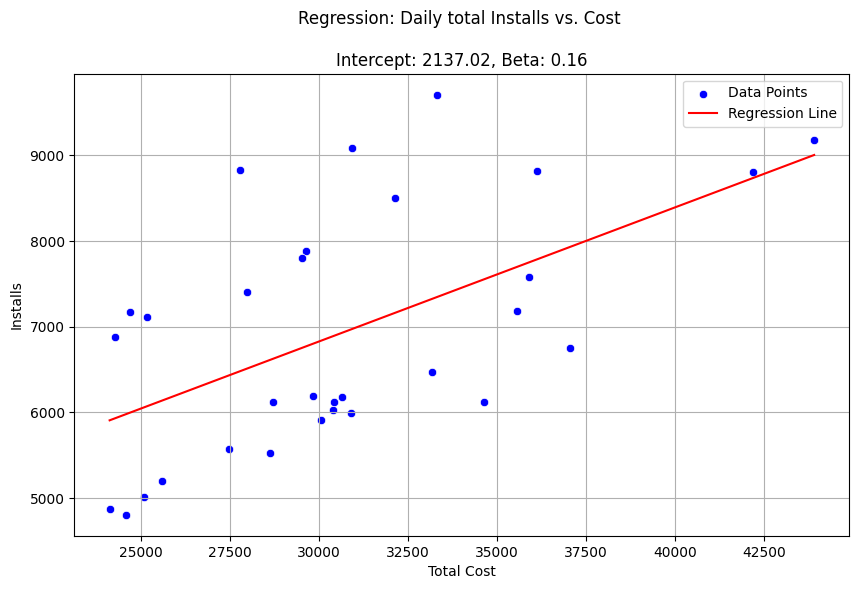

In [49]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Assume cost_per_install is a DataFrame with columns: date, installs, total_cost, etc.

# 1. Aggregate the data by date (summing installs and total_cost for each day)
df_total = cost_per_install.copy()
df_total = df_total.groupby(df_total.index, as_index=False).agg({
    'installs': 'sum',
    'total_cost': 'sum'
})

# 2. Prepare data for regression: regress installs (dependent) on total_cost (predictor)
X = df_total['total_cost'].astype(float).values  # predictor
y = df_total['installs'].astype(float).values      # outcome

# Add a constant term for the intercept
X_const = sm.add_constant(X)

# 3. Run OLS regression
model = sm.OLS(y, X_const).fit()
print(model.summary())

# Extract intercept and beta
intercept, beta = model.params

# 4. Plot the data and the regression line
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_total['total_cost'], y=df_total['installs'], color='blue', label='Data Points')

# Create a sequence of predictor values for plotting the regression line
x_pred = np.linspace(df_total['total_cost'].min(), df_total['total_cost'].max(), 100)
x_pred_const = sm.add_constant(x_pred)
y_pred = model.predict(x_pred_const)

plt.plot(x_pred, y_pred, color='red', label='Regression Line')
plt.xlabel('Total Cost')
plt.ylabel('Installs')
plt.title(f'Regression: Daily total Installs vs. Cost \n\nIntercept: {intercept:.2f}, Beta: {beta:.2f}')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

def regress_installs_on_cost(sub_df, rolling_window=None, min_obs=20):
    """
    For a given DataFrame (grouped by date, country, platform, network)
    with columns 'installs' and 'total_cost', this function computes the rolling
    mean of total_cost (if rolling_window is provided) and regresses installs on
    that rolling cost.

    Parameters:
        sub_df (DataFrame): Must include 'date', 'installs', 'total_cost'
        rolling_window (int or None): Window size for rolling mean.
        min_obs (int): Minimum number of observations required.
    
    Returns:
        statsmodels summary (or None if insufficient data or issues)
    """
    # Sort by date
    sub_df = sub_df.sort_values('date').copy()

    # Compute rolling mean of total_cost if requested; otherwise, use raw cost.
    if rolling_window is not None and rolling_window > 1:
        sub_df['rolling_cost'] = sub_df['total_cost'].rolling(rolling_window).mean()
    else:
        sub_df['rolling_cost'] = sub_df['total_cost']
    
    # Drop rows where rolling_cost is NaN
    sub_df = sub_df.dropna(subset=['rolling_cost'])

    if len(sub_df) < min_obs:
        return None
    
    if np.std(sub_df['rolling_cost']) < 1e-3:
        return None


    # Dependent variable: log of installs (to handle skewness anf to not get negative values)
    y = sub_df['installs'].astype(float).values
    #y = np.log(y + 1)
    # Independent variable: rolling mean of total_cost
    X = sm.add_constant(sub_df['rolling_cost'].astype(float).values)

    # Remove any rows with invalid values
    valid_idx = (~np.isnan(X).any(axis=1)) & (~np.isinf(X).any(axis=1)) & (~np.isnan(y)) & (~np.isinf(y))
    X, y = X[valid_idx], y[valid_idx]

    if len(X) < min_obs:
        return None

    try:
        model = sm.OLS(y, X).fit()
    except Exception as e:
        return None

    return model


df_raw = cost_per_install.copy()


results = {}
for (c, p, n), group in df_raw.groupby(['country', 'platform', 'network']):
    model = regress_installs_on_cost(group, rolling_window=1)  # use rolling_window=1 for raw daily values
    results[(c, p, n)] = model

beta_results = []
for group_key, model in results.items():
    if model is not None:
        beta = model.params[1]
        beta_results.append((group_key, beta))
    else:
        print(f"Insufficient data for {group_key}")

# Sort groups in descending order by beta
beta_results_sorted = sorted(beta_results, key=lambda x: x[1], reverse=True)

print("Groups sorted by beta (rolling_cost coefficient) in descending order:")
for (country, platform, network), beta in beta_results_sorted:
    print("="*70)
    print(f"Country: {country}, Platform: {platform}, Network: {network}")
    print(results[(country, platform, network)].summary())



Insufficient data for ('Mercury', 'android', 'Organic')
Insufficient data for ('Mercury', 'android', 'Sid')
Insufficient data for ('Mercury', 'ios', 'Organic')
Insufficient data for ('Pluton', 'android', 'Jessie')
Insufficient data for ('Pluton', 'android', 'Organic')
Insufficient data for ('Pluton', 'android', 'Woody')
Insufficient data for ('Pluton', 'ios', 'Jessie')
Insufficient data for ('Pluton', 'ios', 'Organic')
Insufficient data for ('Pluton', 'ios', 'Sid')
Insufficient data for ('Pluton', 'ios', 'Woody')
Insufficient data for ('Saturn', 'android', 'Buzz')
Insufficient data for ('Saturn', 'android', 'Jessie')
Insufficient data for ('Saturn', 'android', 'Organic')
Insufficient data for ('Saturn', 'android', 'Sid')
Insufficient data for ('Saturn', 'android', 'Woody')
Insufficient data for ('Saturn', 'ios', 'Buzz')
Insufficient data for ('Saturn', 'ios', 'Organic')
Insufficient data for ('Saturn', 'ios', 'Sid')
Insufficient data for ('Saturn', 'ios', 'Woody')
Insufficient data for

### Monetization Analysis

In [51]:
query = """
WITH daily_revenue AS (
  SELECT
    DATE(r.event_time) AS date,
    i.country,
    r.platform,
    SUM(CAST(r.revenue AS FLOAT64)) AS daily_revenue
  FROM `casedreamgames.case_db.q1_table_revenue` r
  JOIN `casedreamgames.case_db.q1_table_install` i
    ON r.user_id = i.user_id
  GROUP BY date, i.country, r.platform
),
daily_cost AS (
  SELECT
    date,
    country,
    platform,
    SUM(cost) AS daily_cost
  FROM `casedreamgames.case_db.q1_table_cost`
  GROUP BY date, country, platform
)
SELECT
  COALESCE(r.date, c.date) AS date,
  COALESCE(r.country, c.country) AS country,
  COALESCE(r.platform, c.platform) AS platform,
  COALESCE(r.daily_revenue, 0) AS daily_revenue,
  COALESCE(c.daily_cost, 0) AS daily_cost
FROM daily_revenue r
FULL OUTER JOIN daily_cost c
  ON r.date = c.date
  AND r.country = c.country
  AND r.platform = c.platform
ORDER BY date, country, platform;

"""
revenue_cost = analytics._run_query(query)
revenue_cost = revenue_cost.set_index('date')
revenue_cost.head(20)

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country,platform,daily_revenue,daily_cost
date,,,,
2021-04-30,Mercury,android,2.0,0.0
2021-05-01,Mercury,android,80.0,12814.0
2021-05-01,Mercury,ios,46.0,17797.0
2021-05-01,Pluton,android,0.0,308.0
2021-05-01,Pluton,ios,18.0,1168.0
2021-05-01,Saturn,android,0.0,3.0
2021-05-01,Saturn,ios,0.0,4.0
2021-05-01,Uranus,android,0.0,13.0
2021-05-01,Uranus,ios,0.0,32.0


<Axes: title={'center': 'Daily Revenue'}, xlabel='date'>

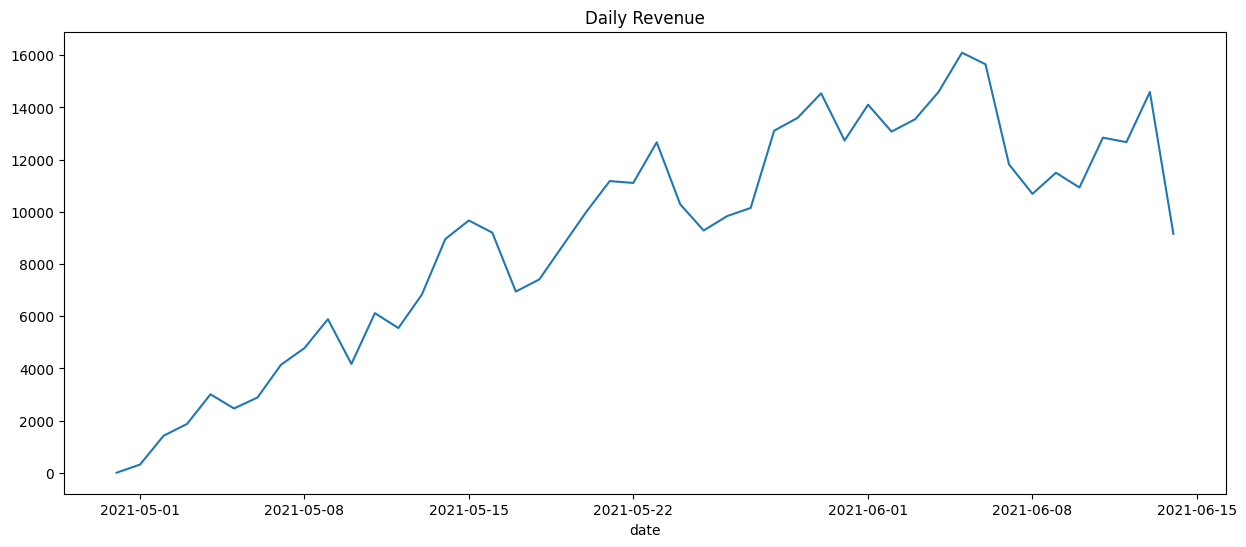

In [52]:
revenue_cost.groupby(revenue_cost.index)['daily_revenue'].sum().plot(title='Daily Revenue', figsize=(15,6))

<Axes: title={'center': 'Daily Cost'}, xlabel='date'>

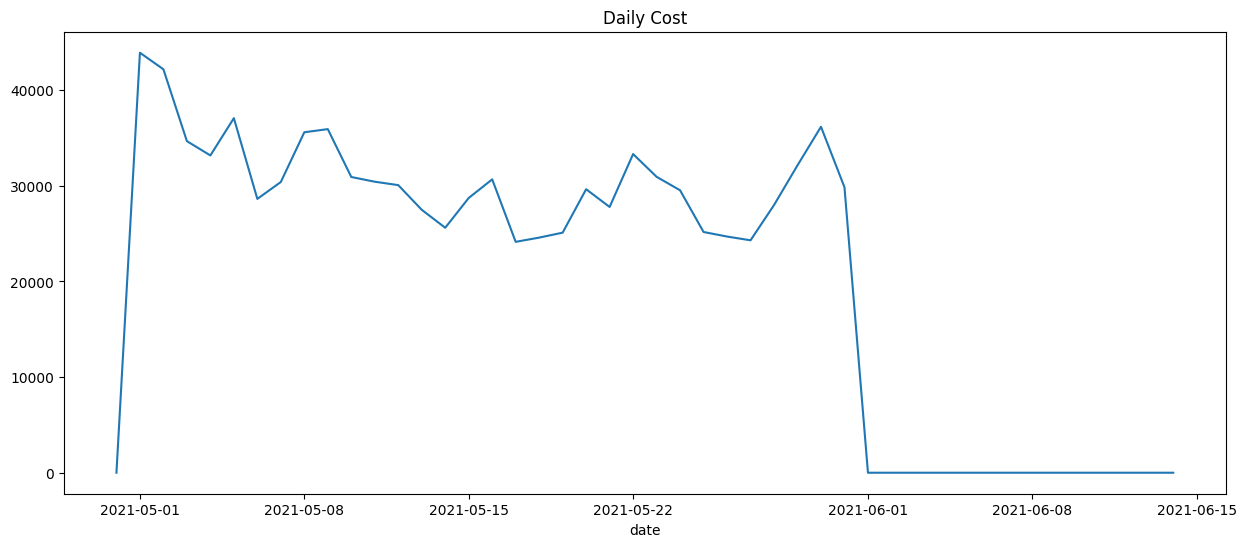

In [53]:
revenue_cost.groupby(revenue_cost.index)['daily_cost'].sum().plot(title='Daily Cost', figsize=(15,6))

<Axes: title={'center': 'Daily Profit'}, xlabel='date'>

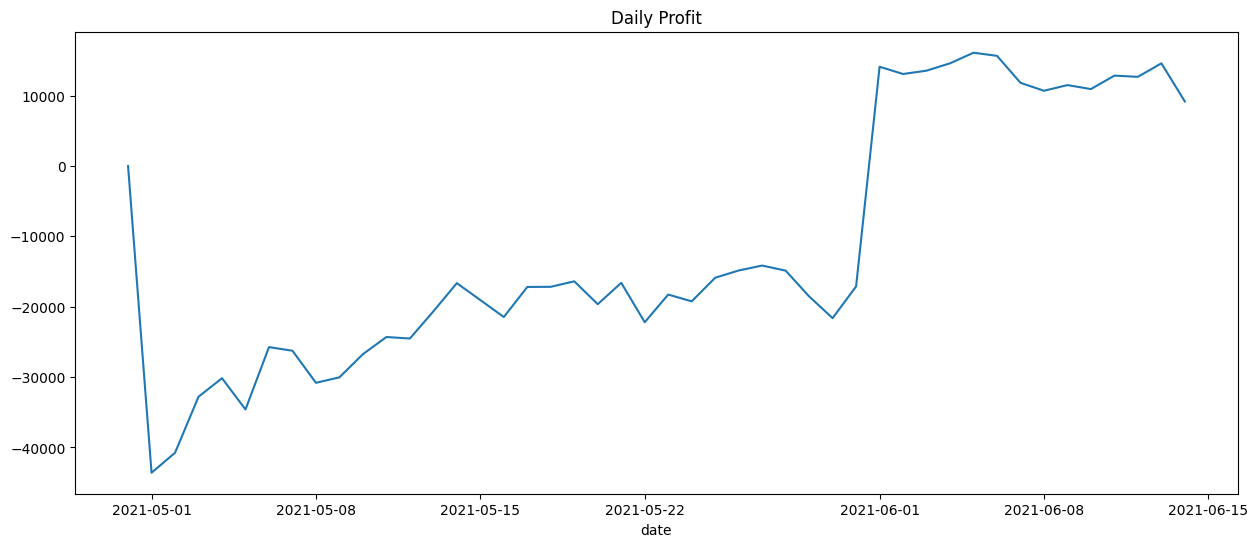

In [54]:
revenue_cost['daily_profit'] = revenue_cost['daily_revenue'] - revenue_cost['daily_cost']
revenue_cost.groupby(revenue_cost.index)['daily_profit'].sum().plot(title='Daily Profit', figsize=(15,6))

<Axes: title={'center': 'Cumulative Profit'}, xlabel='date'>

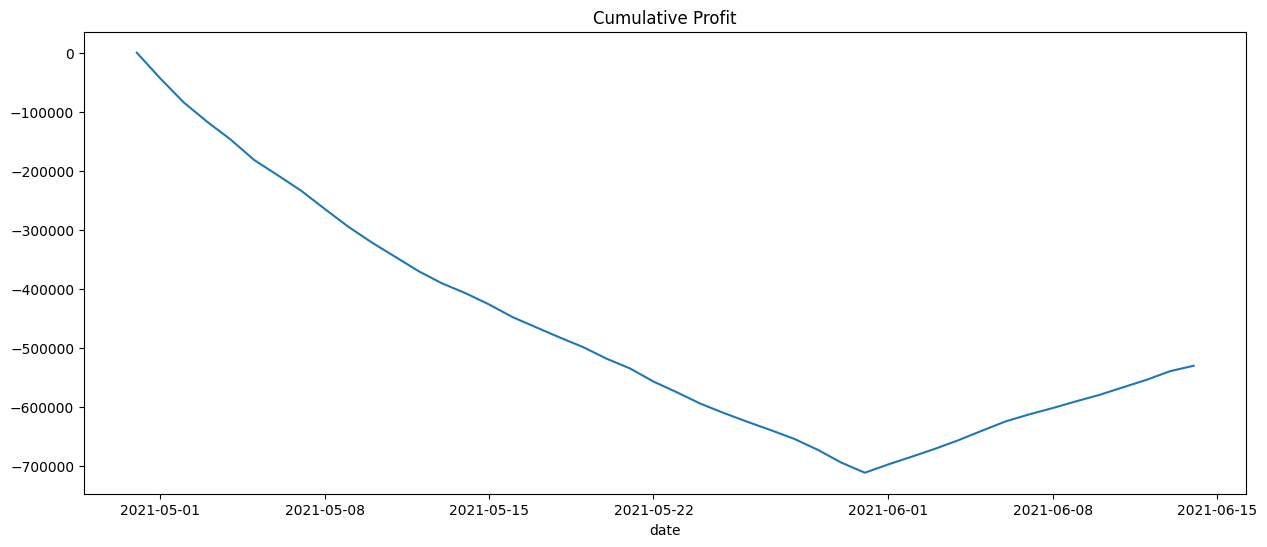

In [55]:
revenue_cost.groupby(revenue_cost.index)['daily_profit'].sum().cumsum().plot(title='Cumulative Profit', figsize=(15,6))


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'ARPU'}, xlabel='date'>

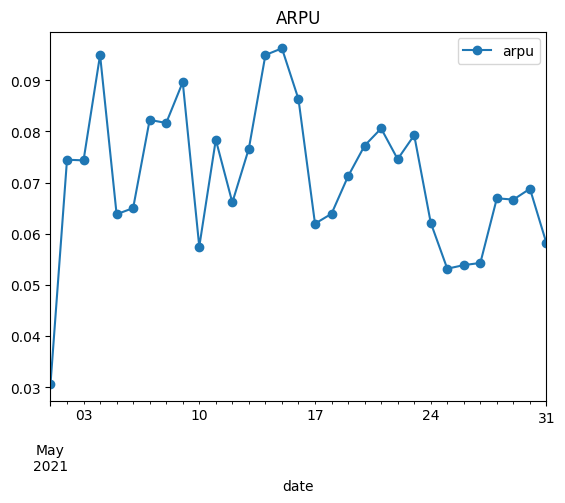

In [56]:
arpu = analytics.get_arpu_trend()
arpu['date'] = pd.to_datetime(arpu['date'])
arpu = arpu.set_index('date')
arpu.iloc[1:-1].plot(title='ARPU', style='o-')


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: title={'center': 'ARPDau'}>

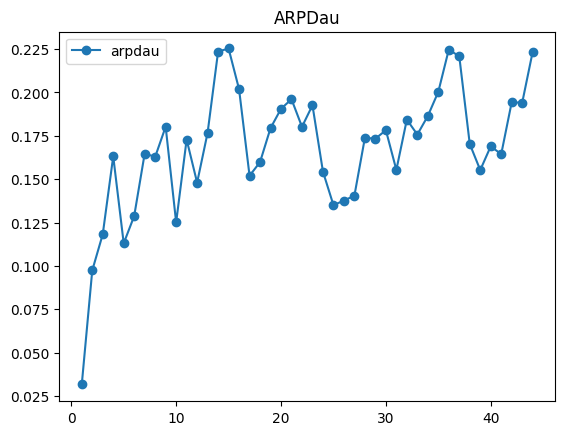

In [57]:
arpdau = analytics.get_arpdau_trend()
arpdau.iloc[1 : -1].plot(style='o-', title='ARPDau')

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

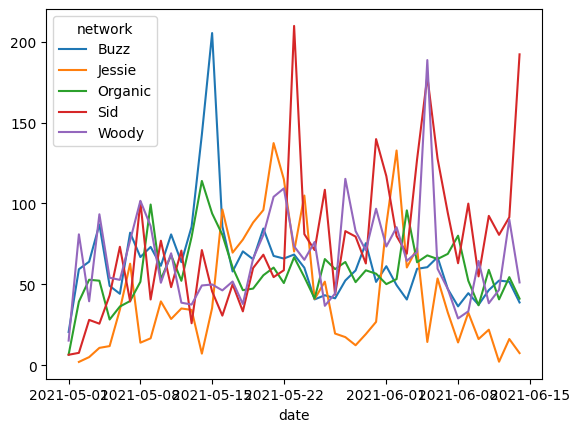

In [58]:
arpdau_by_network = analytics.get_arpdau_by_network()
arpdau_by_network.pivot(index='date', columns='network', values='arpdau').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

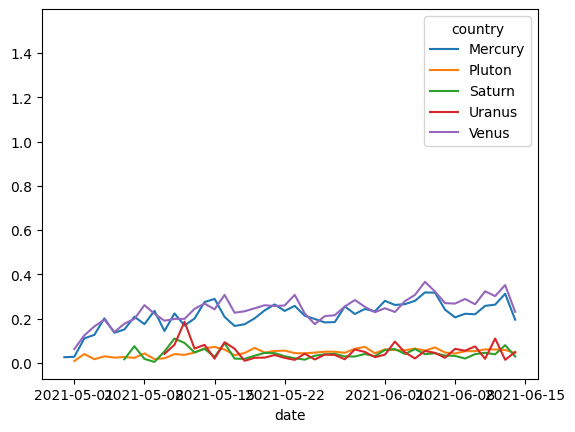

In [59]:
query = """
WITH daily_revenue AS (
  SELECT
    DATE(r.event_time) AS date,
    i.country,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM `casedreamgames.case_db.q1_table_revenue` r
  JOIN `casedreamgames.case_db.q1_table_install` i
    ON r.user_id = i.user_id
  GROUP BY date, i.country
),
daily_active AS (
  SELECT
    DATE(s.event_time) AS date,
    i.country,
    COUNT(DISTINCT s.user_id) AS dau
  FROM `casedreamgames.case_db.q1_table_session` s
  JOIN `casedreamgames.case_db.q1_table_install` i
    ON s.user_id = i.user_id
  GROUP BY date, i.country
)
SELECT
  r.date,
  r.country,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM daily_revenue r
JOIN daily_active d
  ON r.date = d.date AND r.country = d.country
ORDER BY r.date, r.country;

"""
arpdau_by_country = analytics._run_query(query)
#arpdau_by_country = arpdau_by_country.set_index('date')
arpdau_by_country.pivot(index='date', columns='country', values='arpdau').plot()


/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

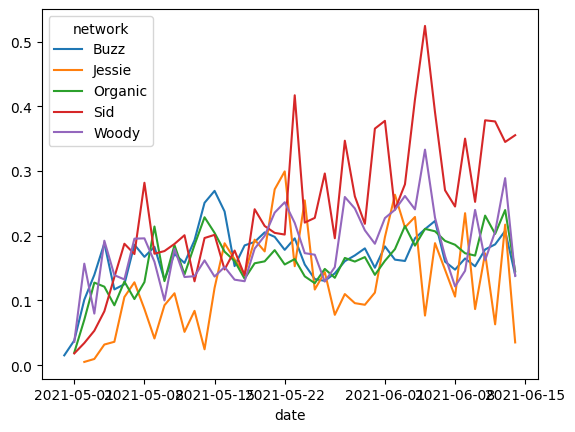

In [60]:
query = """
WITH daily_revenue AS (
  SELECT
    DATE(r.event_time) AS date,
    i.network,
    SUM(CAST(r.revenue AS FLOAT64)) AS total_revenue
  FROM `casedreamgames.case_db.q1_table_revenue` r
  JOIN `casedreamgames.case_db.q1_table_install` i
    ON r.user_id = i.user_id
  GROUP BY date, i.network
),
daily_active AS (
  SELECT
    DATE(s.event_time) AS date,
    i.network,
    COUNT(DISTINCT s.user_id) AS dau
  FROM `casedreamgames.case_db.q1_table_session` s
  JOIN `casedreamgames.case_db.q1_table_install` i
    ON s.user_id = i.user_id
  GROUP BY date, i.network
)
SELECT
  r.date,
  r.network,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM daily_revenue r
JOIN daily_active d
  ON r.date = d.date AND r.network = d.network
ORDER BY r.date, r.network;

"""

arpdau_by_network = analytics._run_query(query)
#arpdau_by_network = arpdau_by_network.set_index('date')
arpdau_by_network.pivot(index='date', columns='network', values='arpdau').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

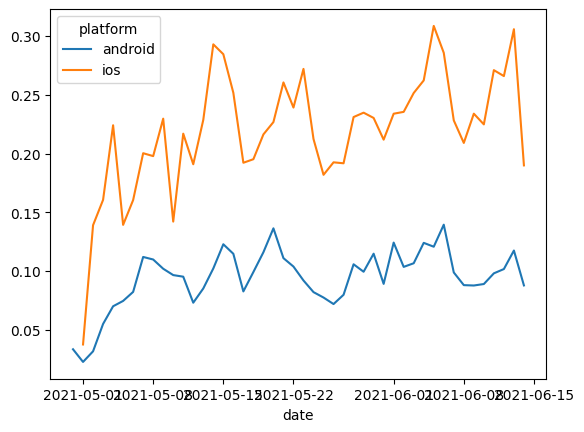

In [61]:
query = """
WITH daily_revenue AS (
  SELECT
    DATE(event_time) AS date,
    platform,
    SUM(CAST(revenue AS FLOAT64)) AS total_revenue
  FROM `casedreamgames.case_db.q1_table_revenue`
  GROUP BY date, platform
),
daily_active AS (
  SELECT
    DATE(event_time) AS date,
    platform,
    COUNT(DISTINCT user_id) AS dau
  FROM `casedreamgames.case_db.q1_table_session`
  GROUP BY date, platform
)
SELECT
  r.date,
  r.platform,
  r.total_revenue,
  d.dau,
  SAFE_DIVIDE(r.total_revenue, d.dau) AS arpdau
FROM daily_revenue r
JOIN daily_active d USING(date, platform)
ORDER BY r.date, r.platform;

"""
arpdau_by_platform = analytics._run_query(query)
#arpdau_by_platform = arpdau_by_platform.set_index('date')
arpdau_by_platform.pivot(index='date', columns='platform', values='arpdau').plot()

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


<Axes: xlabel='date'>

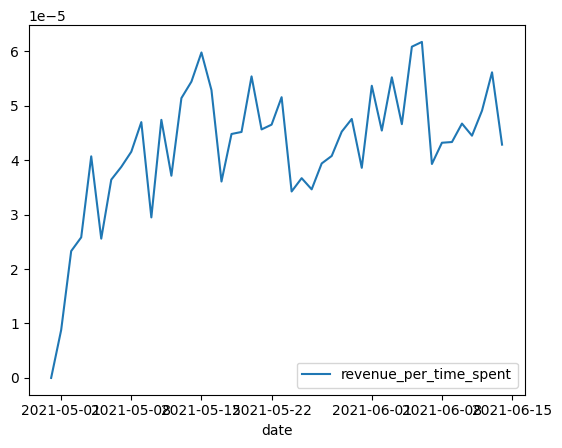

In [62]:
revenue_by_time_spent = analytics.get_revenue_by_time_spent()
revenue_by_time_spent = revenue_by_time_spent.set_index('date')
revenue_by_time_spent.plot()

In [63]:
arpu_by_level_progress = analytics.get_arpu_by_level_progression().fillna(0)
arpu_by_level_progress = arpu_by_level_progress.set_index('max_level')
arpu_by_level_progress

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_count,total_revenue,arpu
max_level,,,
1,8426,12.0,0.001424
2,5542,30.0,0.005413
3,3403,30.0,0.008816
4,3960,30.0,0.007576
5,2523,0.0,0.000000
...,...,...,...
947,2,3045.0,1522.500000
948,8,60.0,7.500000
949,9,277.0,30.777778


<Axes: title={'center': 'user count by max level'}, xlabel='max_level'>

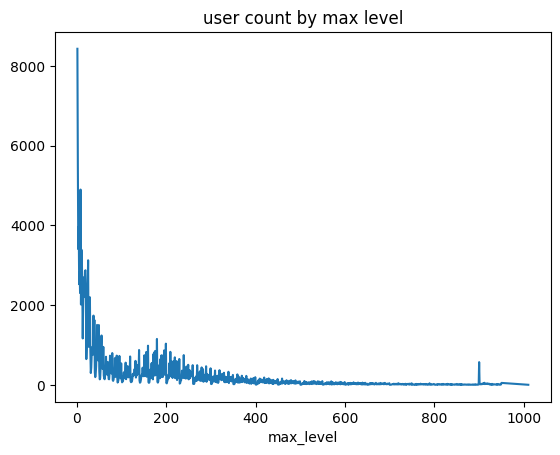

In [64]:
arpu_by_level_progress.user_count.plot(title='user count by max level')

<Axes: title={'center': 'ARPU by Max Level Reached'}, xlabel='max_level'>

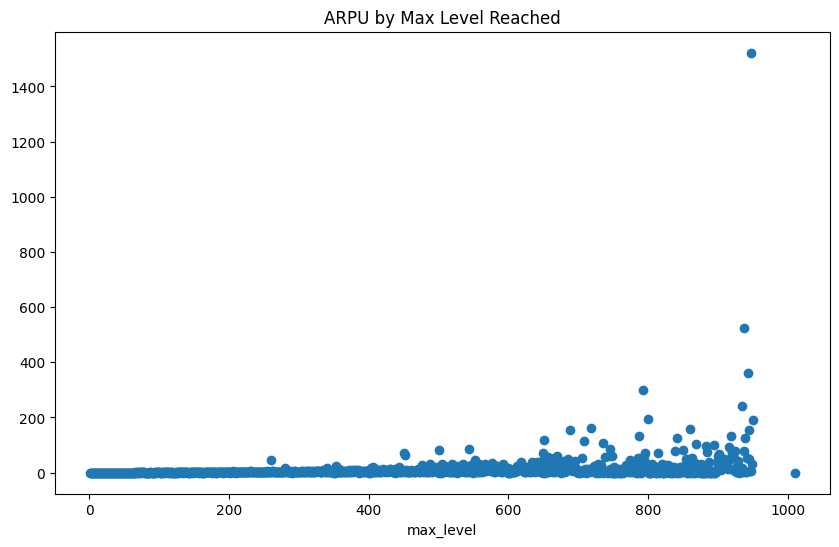

In [65]:
arpu_by_level_progress.arpu.plot(title='ARPU by Max Level Reached', style='o', figsize=(10,6))

<Axes: title={'center': 'log ARPU by Max Level Reached'}, xlabel='max_level'>

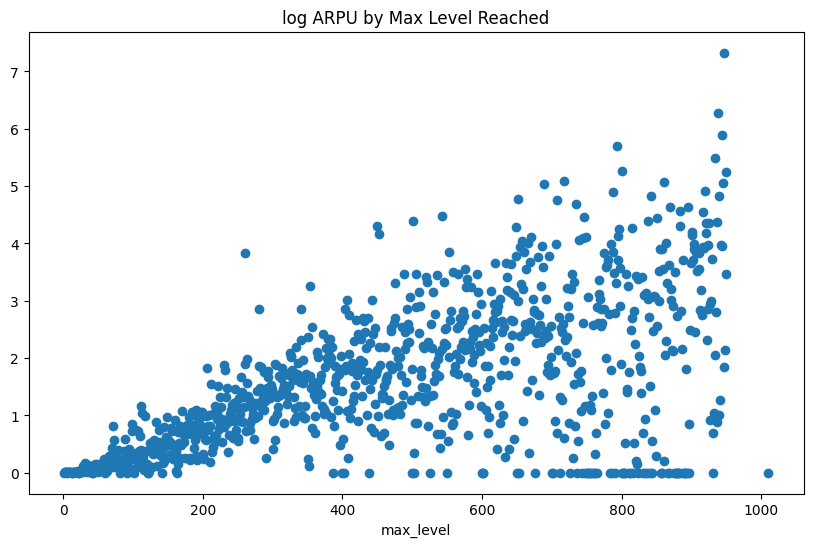

In [66]:
np.log(arpu_by_level_progress.arpu+1).plot(title='log ARPU by Max Level Reached', style='o', figsize=(10,6))


                            OLS Regression Results                            
Dep. Variable:                   arpu   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     474.8
Date:                Thu, 20 Feb 2025   Prob (F-statistic):           1.24e-85
Time:                        12:55:04   Log-Likelihood:                -1406.8
No. Observations:                 948   AIC:                             2818.
Df Residuals:                     946   BIC:                             2827.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3001      0.069      4.326      0.0

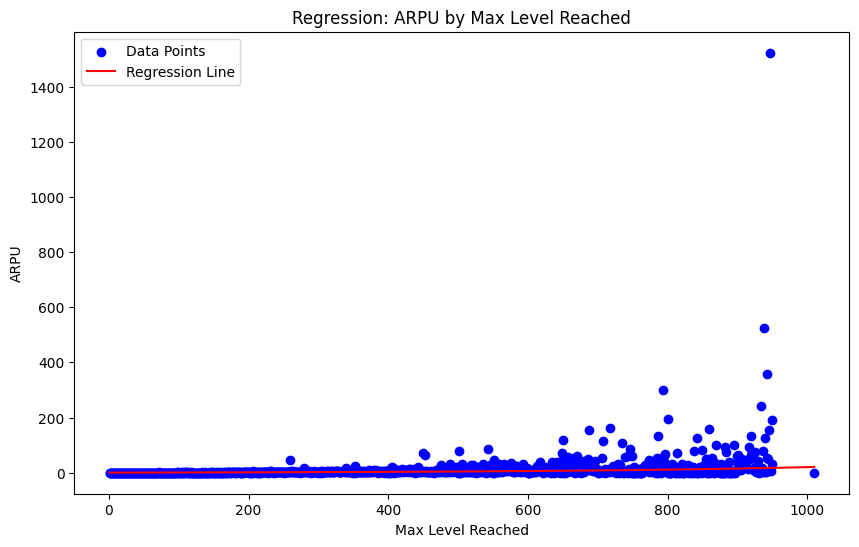

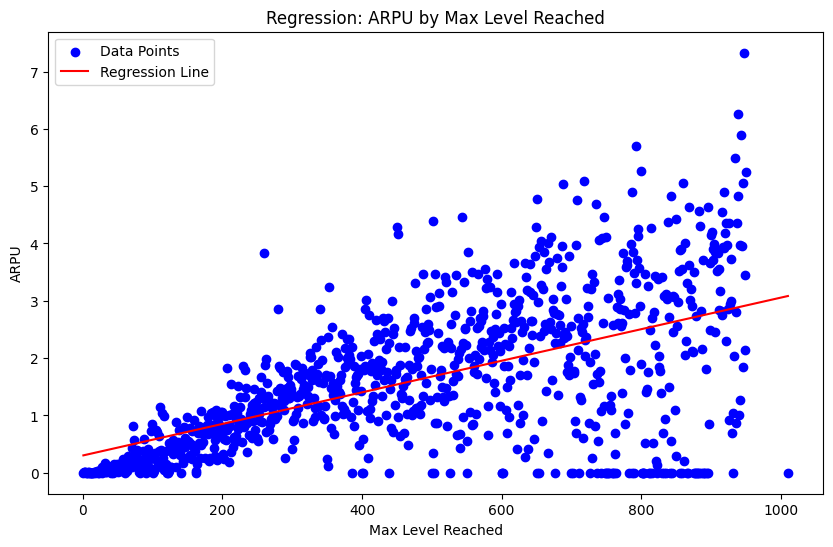

In [67]:
X = sm.add_constant(arpu_by_level_progress.index)
y = np.log(arpu_by_level_progress.arpu + 1)
model = sm.OLS(y, X).fit()
print(model.summary())

## plot the original regression line 
plt.figure(figsize=(10,6))
plt.scatter(arpu_by_level_progress.index, np.exp(y)-1, color='blue', label='Data Points')
plt.plot(arpu_by_level_progress.index, np.exp(model.predict(X))-1, color='red', label='Regression Line')
plt.xlabel('Max Level Reached')
plt.ylabel('ARPU')
plt.title('Regression: ARPU by Max Level Reached')
plt.legend()

## plot the log regression line
plt.figure(figsize=(10,6))
plt.scatter(arpu_by_level_progress.index, y, color='blue', label='Data Points')
plt.plot(arpu_by_level_progress.index, model.predict(X), color='red', label='Regression Line')
plt.xlabel('Max Level Reached')
plt.ylabel('ARPU')
plt.title('Regression: ARPU by Max Level Reached')
plt.legend()


In [68]:
query = """
WITH daily_installs AS (
  SELECT
    DATE(event_time) AS date,
    country,
    platform,
    network,
    COUNT(DISTINCT user_id) AS installs
  FROM `casedreamgames.case_db.q1_table_install`
  GROUP BY date, country, platform, network
),
daily_revenue AS (
  SELECT
    DATE(r.event_time) AS date,
    i.country,
    i.platform,
    i.network,
    SUM(CAST(r.revenue AS FLOAT64)) AS revenue
  FROM `casedreamgames.case_db.q1_table_revenue` r
  JOIN `casedreamgames.case_db.q1_table_install` i
    ON r.user_id = i.user_id
  GROUP BY date, i.country, i.platform, i.network
),
daily_cost AS (
  SELECT
    date,
    country,
    platform,
    network,
    SUM(cost) AS cost
  FROM `casedreamgames.case_db.q1_table_cost`
  GROUP BY date, country, platform, network
)
SELECT
  COALESCE(di.date, dr.date, dc.date) AS date,
  COALESCE(di.country, dr.country, dc.country) AS country,
  COALESCE(di.platform, dr.platform, dc.platform) AS platform,
  COALESCE(di.network, dr.network, dc.network) AS network,
  COALESCE(di.installs, 0) AS installs,
  COALESCE(dr.revenue, 0) AS revenue,
  COALESCE(dc.cost, 0) AS cost
FROM daily_installs di
FULL OUTER JOIN daily_revenue dr
  ON di.date = dr.date
  AND di.country = dr.country
  AND di.platform = dr.platform
  AND di.network = dr.network
FULL OUTER JOIN daily_cost dc
  ON COALESCE(di.date, dr.date) = dc.date
  AND COALESCE(di.country, dr.country) = dc.country
  AND COALESCE(di.platform, dr.platform) = dc.platform
  AND COALESCE(di.network, dr.network) = dc.network
ORDER BY date, country, platform, network;

"""
revenue_cost = analytics._run_query(query)
revenue_cost = revenue_cost.set_index('date')
revenue_cost.head(20)

/home/yusuf/myenv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1820: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,country,platform,network,installs,revenue,cost
date,,,,,,
2021-04-30,Mercury,android,Buzz,85,2.0,0.0
2021-04-30,Mercury,android,Jessie,8,0.0,0.0
2021-04-30,Mercury,android,Organic,25,0.0,0.0
2021-04-30,Mercury,android,Sid,6,0.0,0.0
2021-04-30,Mercury,android,Woody,44,0.0,0.0
2021-04-30,Mercury,ios,Buzz,75,0.0,0.0
2021-04-30,Mercury,ios,Jessie,6,0.0,0.0
2021-04-30,Mercury,ios,Organic,63,0.0,0.0
2021-04-30,Mercury,ios,Sid,7,0.0,0.0


<Axes: title={'center': 'Revenue per Install'}, xlabel='date'>

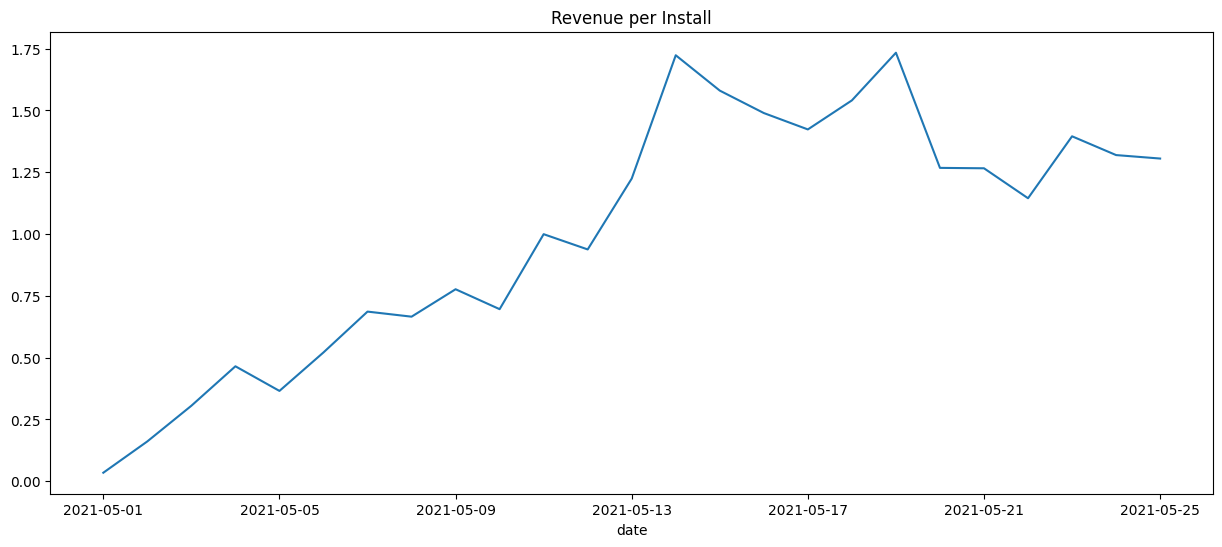

In [69]:
rci = revenue_cost.groupby(revenue_cost.index).agg({'revenue': 'sum', 'cost': 'sum', 'installs' : 'sum'})
(rci.revenue/ rci.installs).iloc[1:-20].plot(title='Revenue per Install', figsize=(15,6))